In [ ]:
#ddpg

In [ ]:
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class Continuous_MountainCarEnv_Custom(gym.Env):
    """
    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with continuous actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    The action is a `ndarray` with shape `(1,)`, representing the directional force applied on the car.
    The action is clipped in the range `[-1,1]` and multiplied by a power of 0.0015.
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t+1</sub> + force * self.power - 0.0025 * cos(3 * position<sub>t</sub>)*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force is the action clipped to the range `[-1,1]` and power is a constant 0.0015.
    The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall.
    The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].
    ### Reward
    A negative reward of *-0.1 * action<sup>2</sup>* is received at each timestep to penalise for
    taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100
    is added to the negative reward for that timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.45 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 999.
    ### Arguments
    ```
    gym.make('MountainCarContinuous-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_action = -1.0
        self.max_action = 1.0
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.max_step = 1000 # change from 999 for convient
        self.current_step = 0

                ### Customization changes ######
        self.tau = 1.0 # seconds between state updates
        self.MRAC = ModelRefAC()
        self.NumIntegrationsSteps = 200
        self.tau1 =self.tau/self.NumIntegrationsSteps
        self.MRAC.timeSample = self.tau1
        self.MRAC.plant.tau1 = self.tau1
        self.MRAC.ref_model.tau1 = self.tau1
        ####
        self.wanted_force = 0.0


        self.goal_position = (
            0.45  # was 0.5 in gym, 0.45 in Arnaud de Broissia's version
        )
        self.goal_velocity = goal_velocity
        self.power = 0.0015

        self.low_state = np.array(
            [self.min_position, -self.max_speed], dtype=np.float32
        )
        self.high_state = np.array(
            [self.max_position, self.max_speed], dtype=np.float32
        )

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Box(
            low=self.min_action, high=self.max_action, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )

    def step(self, action: np.ndarray):

        position = self.state[0]
        velocity = self.state[1]
        #force = min(max(action[0], self.min_action), self.max_action)#The action is clipped in the range [-1,1] and multiplied by a power of 0.0015
        wanted_force = min(max(action, self.min_action), self.max_action)#The action is clipped in the range [-1,1] and multiplied by a power of 0.0015
        self.wanted_force=wanted_force
        for n in np.arange(start=0, stop=self.NumIntegrationsSteps, step=1):
          #generates actual force
          self.MRAC.plant.thetadot = velocity
          actual_force = self.MRAC.step(r=wanted_force)
          #actual_force = wanted_force # change for perfect applying force

          velocity += (actual_force * self.power - 0.0025 * math.cos(3 * position))*self.tau1
          if velocity > self.max_speed:
              velocity = self.max_speed
          if velocity < -self.max_speed:
              velocity = -self.max_speed
          position += (velocity)*self.tau1
          if position > self.max_position:
              position = self.max_position
          if position < self.min_position:
              position = self.min_position
          if position == self.min_position and velocity < 0:
              velocity = 0

        # Convert a possible numpy bool to a Python bool.

        terminated = bool(
            position >= self.goal_position #and velocity >= self.goal_velocity
        )
        '''
        terminated = bool(
            position >= self.goal_position and np.abs(
                velocity-self.goal_velocity) < 10**(-3)
        )
        '''
        reward = 0
        if terminated:
            reward = 100.0
        reward -= math.pow(actual_force, 2) * 0.1
        self.state = np.array([position, velocity], dtype=np.float32)
        # change
        if self.current_step>100:
          reward -= 1e-1


        if self.render_mode == "human":
            self.render()

        self.current_step += 1
        terminated_end_of_episode = bool(self.current_step % self.max_step == 0)
        if (terminated == True) or (terminated_end_of_episode == True):
          terminated = True
          self.current_step = 0



        return self.state, reward, terminated, False ,wanted_force , actual_force

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        self.current_step = 0
        ### reset DC motor init. conditions
        self.MRAC.reset()
        self.MRAC.plant.reset()
        self.MRAC.ref_model.reset()

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32)

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array":
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [ ]:
class ElectricalDCMotorEnv():

  def __init__(self):
    self.Resistor_R = 1.0
    self.inductor_L = 0.1
    self.torque_const_Kt = 1.0
    self.bemf_const_Ke = 1.0
    self.tau1 = 0.05
        #
    self.current = 0.0
    self.voltage_input = None
    self.thetadot = 0.0

  def step(self, u):
    voltage_BEMF = self.thetadot*self.bemf_const_Ke
    self.voltage_input = np.clip(u, -10, 10)

    f1 = self.torque_const_Kt*self.current
    self.current += self.tau1*(self.voltage_input-voltage_BEMF-self.current*self.Resistor_R)/self.inductor_L
    f2 = self.torque_const_Kt*self.current
    F = f2
    return F # return actual applied torque

  def reset(self):
    self.current = 0.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ReferenceModel():

  def __init__(self):
    self.a_m = 50.0#30.0
    self.b_m = self.a_m
    self.tau1 = 0.05
    self.x_m = 0.0
    self.y_m = 0.0

  def step(self, r):

    #fwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #self.y_m = self.x_m+0
    #self.x_m = (1+A)*self.y_m+Br
    #y_m = self.y_m+0

    #bkwd integration
    #A = -self.a_m*self.tau1
    #Br = self.b_m*self.tau1*r
    #if A ==1:
    #  C=1
    #else:
    #  C = 1/(1-A)
    #self.y_m = C*(self.x_m-Br)
    #self.x_m = self.y_m+0
    #y_m = self.y_m+0

    #trapz integragration
    A = -0.5*self.a_m*self.tau1
    Br= +0.5*self.b_m*self.tau1*r
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    x_m = self.x_m
    y_m = C*(x_m+Br)
    x_m = (1+A)*y_m + Br
    self.x_m = x_m
    self.y_m = y_m

    return y_m

  def reset(self):
    self.x_m = 0.0
    self.y_m = 0.0

In [ ]:
class ModelRefAC:

  def __init__(self): #  order of signals [r,y,r-y,w]
    self.plant = ElectricalDCMotorEnv()
    self.ref_model = ReferenceModel()
    self.w = 0.0
    self.u = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0
    self.adaptation_gain=np.array([50,60,10,50]) # positive scalar or np.array shape (4,)
    self.sigma_mod_adapt_gain=0 # non-neg scalar or np.array shape (4,)
    self.emod_adapt_gain=0
    self.dead_zone_threshold = 0*1e-5
    self.dead_zone_adapt_gain = 0*1e-3
    self.timeSample=0.05
    self.mu0 = np.array([1e-3,-1e-3,1e-3,1e-3])
    self.std = 0*1e-6
    self.k_temp = self.mu0
    self.k_hat =  self.mu0
    self.keep_coeff = True
    self.mask = np.array([True,True,True,True])
    self.distrib = np.random.standard_normal


  def step(self, r):
    self.r = r
    self.w = self.plant.thetadot
    y = self.y
    y_m = self.y_m
    e=y-y_m
    u = self.adaptationControlLaw(e=e, r=r, y=y, w=self.w)
    self.y_m = self.ref_model.step(r)
    self.y = self.plant.step(u)
    return self.y

  def adaptationControlLaw(self, e, r, y, w):
    v = np.array([r,y,r-y,w])#.clip(-20,20)
    e_norm = abs(e)

    #fwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #self.k_hat = self.k_temp*self.mask
    #self.k_temp = ((1+A)*self.k_hat + Bev)*self.mask

    #backwd integration
    #A = -(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    #Bev = -self.adaptation_gain*self.timeSample*e*v
    #if e_norm<=self.dead_zone_threshold:
    #  A = A*self.dead_zone_adapt_gain
    #  Bev = Bev*self.dead_zone_adapt_gain
    #C = 1-A*(A!=np.ones_like(A))
    #C = 1/C
    #self.k_hat = C*(self.k_temp+Bev)*self.mask
    #self.k_temp = A*self.k_hat*self.mask

    #trapz integration
    A = -0.5*(self.sigma_mod_adapt_gain+self.emod_adapt_gain*e_norm)*self.timeSample
    Bev = -0.5*self.adaptation_gain*self.timeSample*e*v
    if e_norm<=self.dead_zone_threshold:
      A = A*self.dead_zone_adapt_gain
      Bev = Bev*self.dead_zone_adapt_gain
    if A ==1:
      C=1
    else:
      C = 1/(1-A)
    self.k_hat = C*((self.k_temp +Bev)*self.mask)
    self.k_temp = ((1+A)*self.k_hat +Bev)*self.mask
    u = np.dot(v,self.k_hat)
    u=np.clip(u,-10,10)
    self.u = u
    return u

  def reset(self):
    self.w = 0.0
    self.r = 0.0
    self.y = 0.0
    self.y_m = 0.0
    mu0 = self.mu0
    sigma0 = self.std
    keep_coeff = self.keep_coeff
    self.k_temp = (sigma0*self.distrib(self.k_temp.shape) + keep_coeff*self.k_temp + (not keep_coeff)*mu0)*self.mask
    self.k_hat = (sigma0*self.distrib(self.k_hat.shape) + keep_coeff*self.k_hat + (not keep_coeff)*mu0)*self.mask


In [ ]:
from gym import make
import random
import numpy as np
from collections import namedtuple, deque
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
Transaction = namedtuple('Transaction',
                         ('state', 'action', 'next_state', 'reward'))


class Buffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.appendleft(Transaction(*args))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = Transaction(*zip(*batch))
        self.state = torch.tensor(batch.state, dtype = torch.float)
        self.action = torch.tensor(batch.action, dtype = torch.float)
        self.next_state = torch.tensor(batch.next_state, dtype = torch.float)
        self.reward = torch.tensor(batch.reward, dtype = torch.float)

    def __len__(self):
        return len(self.memory)

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)#(64, 64)
        self.fc3 = nn.Linear(64, action_dim) #64


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64 + action_dim, 64)
        self.fc3 = nn.Linear(64, action_dim)


    def forward(self, x, a):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(torch.cat([x, a], dim=1)))
        x = self.fc3(x)
        return x

In [ ]:
class Noise:
    def __init__(self, mu=0.0, theta=0.1, sigma=0.1):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.action_dim = 1
        self.low = -1.0
        self.high = 1.0
        self.state = np.ones(self.action_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

In [ ]:
class AQL:
    def __init__(self, states, actions, eps, episodes, batch_size, mem_sz, alpha_actor,
                 alpha_critic, gamma, tau):
        self.gamma = gamma
        self.alpha_actor = alpha_actor
        self.alpha_critic = alpha_critic
        self.eps = eps
        self.episodes = episodes
        self.batch_size = batch_size
        self.memory = Buffer(mem_sz)
        self.tau = tau
        self.noise = Noise()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.actor = Actor(states, actions).to(self.device).apply(self.weights)
        self.critic = Critic(states, actions).to(self.device).apply(self.weights)

        self.actor_target = Actor(states, actions).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic_target = Critic(states, actions).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optim = optim.Adam(self.actor.parameters(), lr=self.alpha_actor)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=self.alpha_critic)
        self.critic_criterion = nn.MSELoss()

    @staticmethod
    def weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.xavier_normal_(layer.weight)

    def update(self):
        if len(self.memory) <= self.batch_size:
            return
        self.memory.sample(self.batch_size)
        Qvals = self.critic.forward(self.memory.state, self.memory.action.unsqueeze(1))
        next_actions = self.actor_target.forward(self.memory.next_state)
        next_Q = self.critic_target.forward(self.memory.next_state, next_actions.detach())
        Qprime = self.memory.reward.unsqueeze(1) + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)
        policy_loss = -self.critic.forward(self.memory.state, self.actor.forward(self.memory.state)).mean()

        self.actor_optim.zero_grad()
        policy_loss.backward()
        self.critic_optim.zero_grad()
        critic_loss.backward()

        for param_actor, param_critic in zip(self.actor.parameters(), self.critic.parameters()):
            param_actor.grad.data.clamp_(-1, 1)
            param_critic.grad.data.clamp_(-1, 1)
        self.actor_optim.step()
        self.critic_optim.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

    def act(self, state):
        return np.clip(self.actor(state).detach() + self.eps * self.noise.noise(), -1.0, 1.0)

In [ ]:
class Test:
    def __init__(self, path, rewards, test_episodes, mu0):
        self.rewards = rewards
        self.test_episodes = test_episodes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torch.load(path).to(self.device)
        self.mu0=mu0
        self.run()

    def act(self, state):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        with torch.no_grad():
            return self.model(state)

    def run(self):
        env = Continuous_MountainCarEnv_Custom()
        env.MRAC.mu0 = self.mu0+0
        env.MRAC.k_hat = self.mu0+0
        env.MRAC.k_temp = self.mu0+0
        rewards = []
        for i in range(self.test_episodes):
            state = env.reset()
            s = np.expand_dims(state, axis=0)
            total_reward = 0
            done = False
            while not done:
                k_hat_print = env.MRAC.k_hat.round(2)
                action = self.act(s).item()
                next_state, reward, done, _ , wanted_force , actual_force = env.step(action) #  self.state, reward, terminated, False , force , u_after_pid
                total_reward += reward
                state = next_state
                s = np.expand_dims(state, axis=0) #change
            rewards.append(total_reward)
            print(f'Test Ep.{i}: ', "adapt. coeffs at final time step: ", k_hat_print, f' total reward: {total_reward:.3f}')
        self.test_rewards = rewards
        self.m = np.mean(rewards)
        print(f'Test mean reward:{self.m:.3f}')

    def picture(self):
        plt.figure(figsize=(16, 16))
        ax1 = plt.subplot(421)
        ax2 = plt.subplot(422)
        ax1.plot(np.arange(0, len(self.rewards)), self.rewards, label=f'rewards')
        ax1.set_title(f'Train')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.grid()
        ax1.legend()

        ax2.plot(np.arange(0, len(self.test_rewards)), self.test_rewards, label=f'rewards')
        ax2.axhline(y=self.m, color='r', linestyle='--', label=f'mean reward: {self.m:.3f}')
        ax2.set_title(f'Test')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Reward')
        ax2.legend()
        ax2.grid()
        plt.show()

In [ ]:
env = Continuous_MountainCarEnv_Custom()
variable = 12061997
env.seed(variable)
np.random.seed(variable)
random.seed(variable)
torch.manual_seed(variable)

aql = AQL(states=env.observation_space.shape[0], actions=env.action_space.shape[0],
          eps=1.0, episodes=200, batch_size=64, mem_sz=60000,
          alpha_actor=1e-3, alpha_critic=5e-4, gamma=0.85, tau=0.45)

rewards = []
score = deque(maxlen=5)
best_score = -10000

In [ ]:
ploting_adapt_coeff=[]
k_hat_print = env.MRAC.mu0
print('Initial adapt. coeffs: ', k_hat_print)

for i in range(aql.episodes):
    state = env.reset()
    s = np.expand_dims(state, axis=0)
    total_reward = 0
    done = False
    while not done:
      k_hat_print = env.MRAC.k_hat.round(2)
      action = aql.act(torch.tensor(s, dtype = torch.float).unsqueeze(0)).item()
      next_state, reward, done, _ , wanted_force , actual_force= env.step(action) # self.state, reward, terminated, False , force , u_after_pid

      total_reward += reward
      reward += 13 * abs(next_state[1])#*13

      aql.memory.push(state, action, next_state, reward)
      state = next_state
      s = np.expand_dims(state, axis=0) ####change
      aql.update()
    aql.eps *= 0.9
    score.appendleft(total_reward)
    ploting_adapt_coeff.append(k_hat_print)
    # save best five episodes
    print(f"Episode {i}, ", "adapt. coeffs at final time step: ", k_hat_print)
    print(f'Episode {i},'
          f'total_reward: {total_reward:.3f},'
          f' mean five: {np.mean(score):.3f},'
          f' total mean {np.mean(rewards):.3f},'
          f' EPS: {aql.eps:.2e}')
    if np.mean(score) > best_score and i >= 5:
        torch.save(aql.actor, "model.pickle")
        best_score = np.mean(score)
        print('updated!!!!', f"{best_score:.3f}", '---------------------')
    rewards.append(total_reward)


Initial adapt. coeffs:  [ 0.001 -0.001  0.001  0.001]
Episode 0,  adapt. coeffs at final time step:  [ 2.37 -1.39  0.71  0.56]
Episode 0,total_reward: -114.857, mean five: -114.857, total mean nan, EPS: 9.00e-01
Episode 1,  adapt. coeffs at final time step:  [ 2.63 -1.64  0.8   0.74]
Episode 1,total_reward: -99.540, mean five: -107.198, total mean -114.857, EPS: 8.10e-01
Episode 2,  adapt. coeffs at final time step:  [ 2.72 -1.72  0.83  0.77]
Episode 2,total_reward: -102.893, mean five: -105.763, total mean -107.198, EPS: 7.29e-01
Episode 3,  adapt. coeffs at final time step:  [ 2.76 -1.76  0.85  0.83]
Episode 3,total_reward: -97.479, mean five: -103.692, total mean -105.763, EPS: 6.56e-01
Episode 4,  adapt. coeffs at final time step:  [ 2.79 -1.78  0.85  0.97]
Episode 4,total_reward: -95.621, mean five: -102.078, total mean -103.692, EPS: 5.90e-01
Episode 5,  adapt. coeffs at final time step:  [ 2.8  -1.8   0.86  0.99]
Episode 5,total_reward: -98.842, mean five: -98.875, total mean -1

Test Ep.0:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.701
Test Ep.1:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.741
Test Ep.2:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.701
Test Ep.3:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.894
Test Ep.4:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.752
Test Ep.5:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.764
Test Ep.6:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.870
Test Ep.7:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.796
Test Ep.8:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.821
Test Ep.9:  adapt. coeffs at final time step:  [ 2.83 -1.83  0.87  0.93]  total reward: 93.851
Test Ep.10:  adapt. coeffs at final time step:  [ 

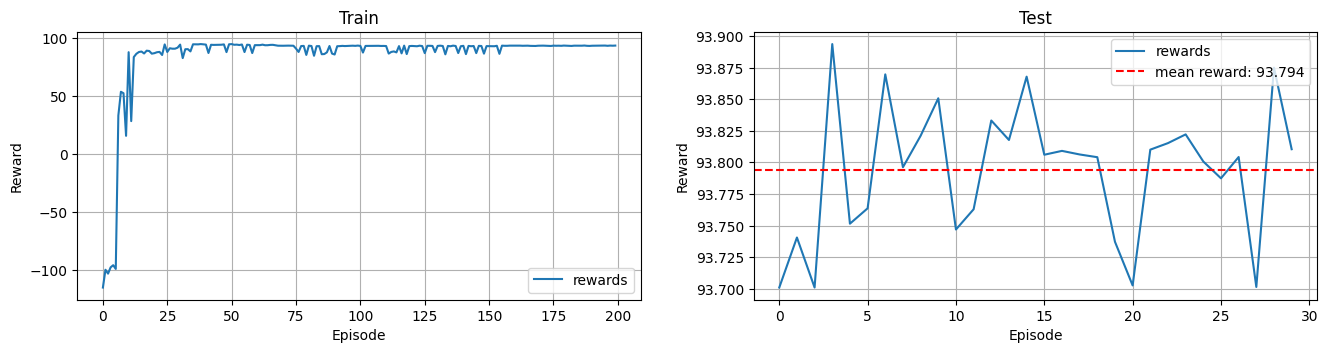

In [ ]:
Test('model.pickle', rewards, 30, mu0 = k_hat_print).picture()

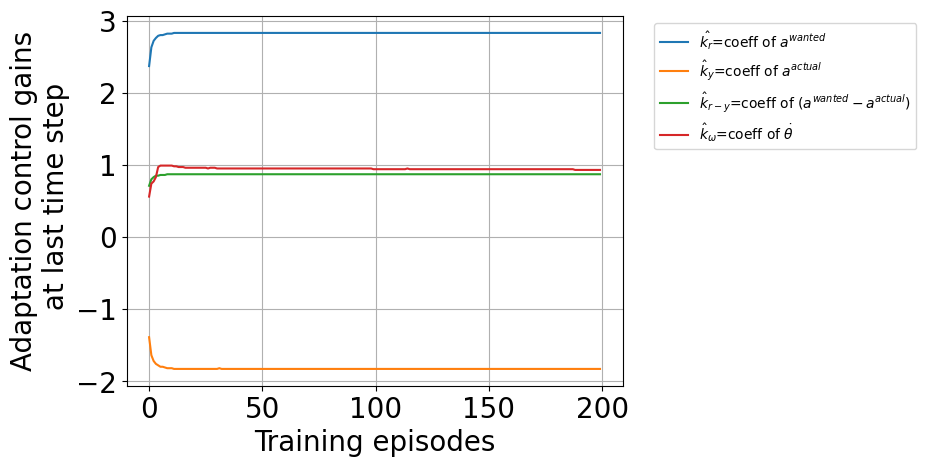

In [ ]:
font = {'size': 20}
plt.rc('font', **font)
plt.plot(ploting_adapt_coeff)
plt.xlabel("Training episodes")
plt.ylabel("Adaptation control gains\n at last time step")
#plt.rc('axes', labelsize=30)

plt.grid()
plt.legend(labels=[r"$\hat{k_r}$=coeff of $a^{wanted}$",
                   r"$\hat{k}_y$=coeff of $a^{actual}$",
                 r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$",
                 r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"], fontsize=10
           , bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

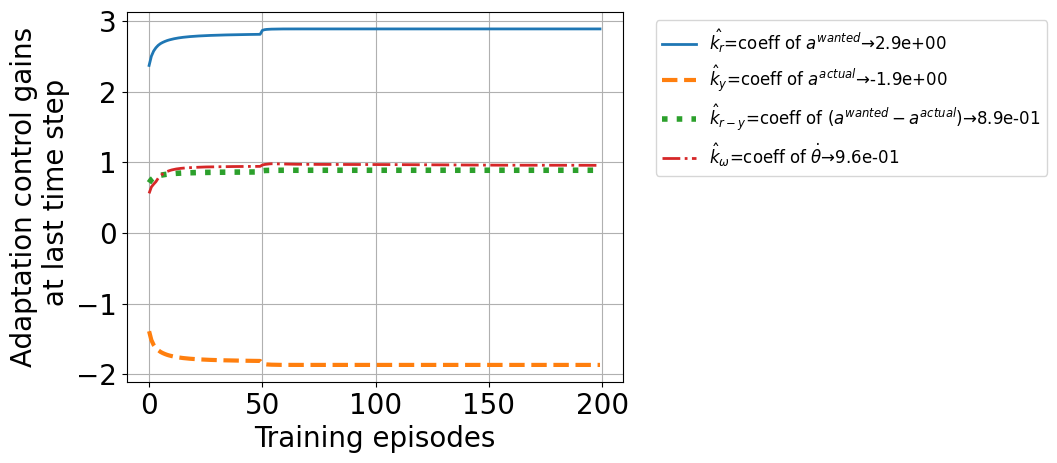

In [ ]:
N=50
# Compute the moving average of the last 50 numbers
moving_average = []
for i, n in enumerate(ploting_adapt_coeff):
    if i < N:
        # If there are not enough previous elements,
        # append the average of all available elements
        avg = sum(ploting_adapt_coeff[:i+1]) / (i+1)
    else:
        # Otherwise, compute the average of the previous 5 elements
        avg = sum(ploting_adapt_coeff[i-N:i+1]) / N
    moving_average.append(avg)
moving_average = np.array(moving_average).T
# Plot the moving average

plt.plot(moving_average[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{moving_average[0,-20:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(moving_average[1],'--',
         label = r"$\hat{k}_y$=coeff of $a^{actual}$"+f"→{moving_average[1,-20:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(moving_average[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{moving_average[2,-20:-1].mean():.1e}",color="C2",linewidth = 4)
plt.plot(moving_average[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{moving_average[3,-20:-1].mean():.1e}",color="C3",linewidth = 2)
#plt.plot(moving_average)
plt.xlabel("Training episodes")
plt.ylabel("Adaptation control gains\n at last time step")
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
'''
class :
    def __init__(self, path, rewards, test_episodes, mu0):
        self.rewards = rewards
        self.test_episodes = test_episodes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torch.load(path).to(self.device)
        self.mu0=mu0
        self.run()

    def act(self, state):
        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)
        with torch.no_grad():
            return self.model(state)
  '''

'\nclass :\n    def __init__(self, path, rewards, test_episodes, mu0):\n        self.rewards = rewards\n        self.test_episodes = test_episodes\n        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n        self.model = torch.load(path).to(self.device)\n        self.mu0=mu0\n        self.run()\n\n    def act(self, state):\n        state = torch.tensor(state, dtype = torch.float).unsqueeze(0)\n        with torch.no_grad():\n            return self.model(state)\n  '

In [ ]:
final_actor = torch.load('model.pickle').to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tmax=90
done_and_t_less_tmax=False
while (not done_and_t_less_tmax):
  t=0
  save_wanted_force = [0]
  save_actual_force = [0]
  save_model_force = [0]
  save_ctrl_voltage = []
  save_MRAC_adapt_gains = []
  save_observation = []

  state = env.reset()
  s = np.expand_dims(state, axis=0)

  save_MRAC_adapt_gains.append(env.MRAC.k_hat)
  save_observation.append(state)
  u0=env.MRAC.adaptationControlLaw(e=env.MRAC.y-env.MRAC.y_m,
                                    r=env.MRAC.r,y=env.MRAC.y,
                                    w=env.MRAC.w)
  save_ctrl_voltage.append(u0)

  done = False
  while not done:
    s = torch.tensor(s, dtype = torch.float).unsqueeze(0)
    with torch.no_grad():
      a = final_actor(s)
    action = a.item()
    next_state, reward, done, _ , wanted_force , actual_force= env.step(action)
    save_observation.append(next_state)
    save_wanted_force.append(wanted_force)
    save_actual_force.append(actual_force)
    save_model_force.append(env.MRAC.y_m)
    save_ctrl_voltage.append(env.MRAC.u)
    save_MRAC_adapt_gains.append(env.MRAC.k_hat)
    state = next_state
    s = np.expand_dims(state, axis=0) ####change
    t+=1
  done_and_t_less_tmax = t<tmax

In [ ]:
print("Car reached goal after",t, "sec")

Car reached goal after 69 sec


In [ ]:
dt=env.tau

In [ ]:
print(dt)

1.0


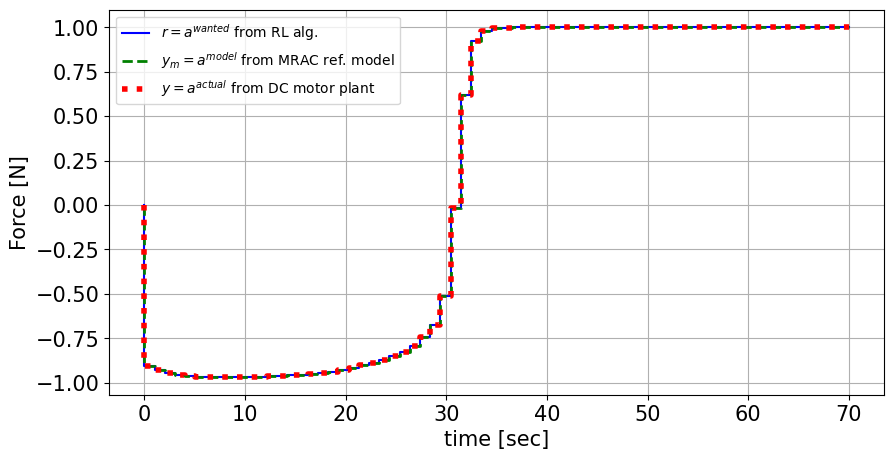

In [ ]:
time_ = np.linspace(start = 0, stop = len(save_actual_force)* dt,num=len(save_actual_force) )

font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


plt.step(time_, save_wanted_force ,label = r"$r=a^{wanted}$ from RL alg.",color="blue",linewidth = 1.5)
plt.step(time_, save_model_force , '--',label = "$y_m=a^{model}$ from MRAC ref. model",color="green",linewidth = 2)
plt.step(time_, save_actual_force , ':',label = "$y=a^{actual}$ from DC motor plant",color="red",linewidth = 4)
plt.xlabel("time [sec]")
plt.ylabel("Force [N]")
plt.legend(fontsize=10)
plt.grid()
plt.show()

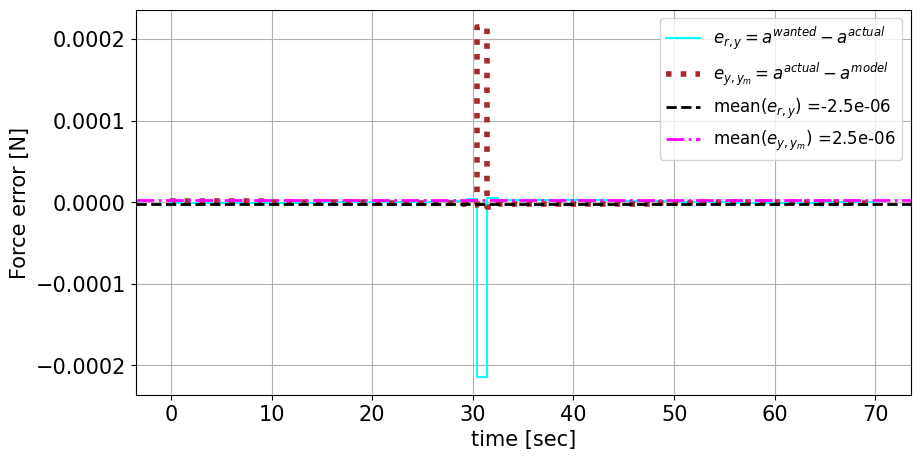

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_force)-np.array(save_actual_force)
e_yy_m=np.array(save_actual_force)-np.array(save_model_force)


plt.step(time_, e_ry ,label = "$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)
plt.axhline(y=e_ry.mean(), color="black",linewidth = 2, linestyle='--', label='mean($e_{r,y}$) =' +f'{e_ry.mean():.1e}')
plt.axhline(y=e_yy_m.mean(), color="magenta",linewidth = 2, linestyle='-.', label='mean($e_{y,y_m}$) =' +f'{e_yy_m.mean():.1e}')


plt.xlabel("time [sec]")
plt.ylabel("Force error [N]")
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
from scipy.integrate import cumulative_trapezoid

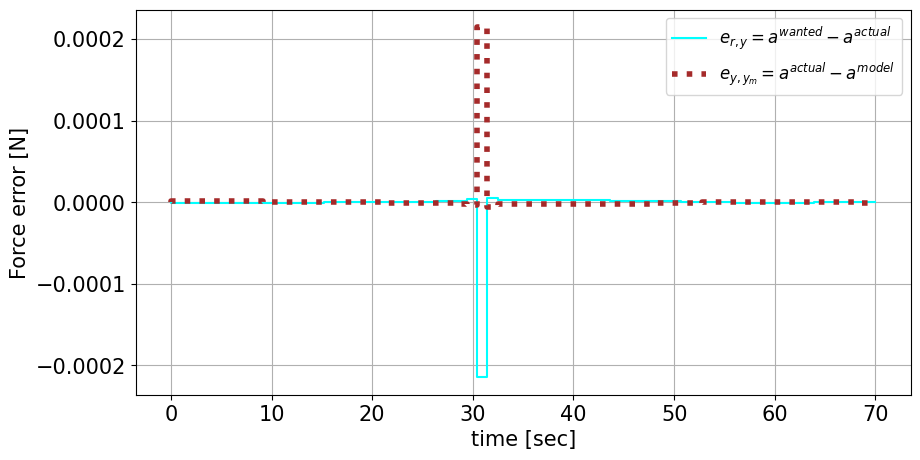

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_force)-np.array(save_actual_force)
e_yy_m=np.array(save_actual_force)-np.array(save_model_force)


plt.step(time_, e_ry ,label = r"$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)

plt.xlabel("time [sec]")
plt.ylabel("Force error [N]")
plt.legend(fontsize=12)
plt.grid()
plt.show()

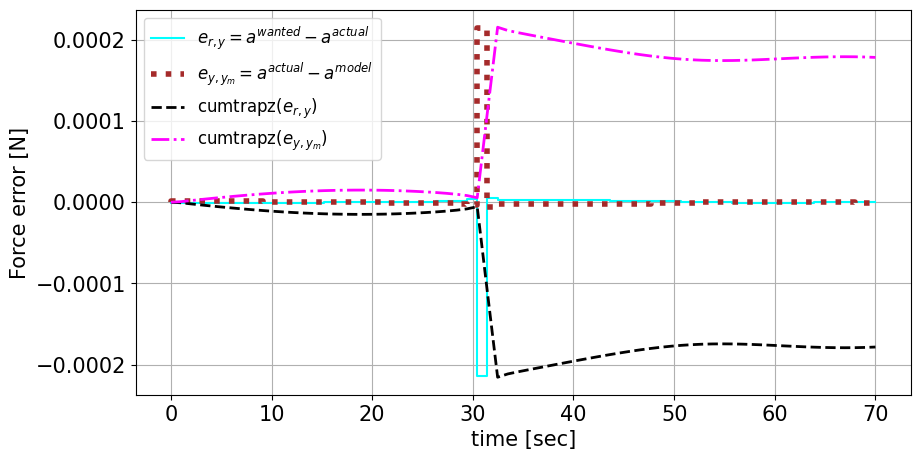

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

e_ry=np.array(save_wanted_force)-np.array(save_actual_force)
e_yy_m=np.array(save_actual_force)-np.array(save_model_force)

cum_trapz_e_ry = cumulative_trapezoid(y=np.r_[0,e_ry],x=None, dx=dt)
cum_trapz_e_yy_m = cumulative_trapezoid(y=np.r_[0,e_yy_m],x=None, dx=dt)


plt.step(time_, e_ry ,label = r"$e_{r,y}=a^{wanted}-a^{actual}$ ",color="cyan",linewidth = 1.5)
plt.step(time_, e_yy_m , ':',label = "$e_{y,y_m}=a^{actual}-a^{model}$ ",color="brown",linewidth = 4)

plt.plot(time_, cum_trapz_e_ry,'--',
         label = r"cumtrapz($e_{r,y}$)",color="black",linewidth = 2)
plt.plot(time_, cum_trapz_e_yy_m,'-.',
         label = r"cumtrapz($e_{y,y_m}$)",color="magenta",linewidth = 2)

plt.xlabel("time [sec]")
plt.ylabel("Force error [N]")
plt.legend(fontsize=12)
plt.grid()
plt.show()

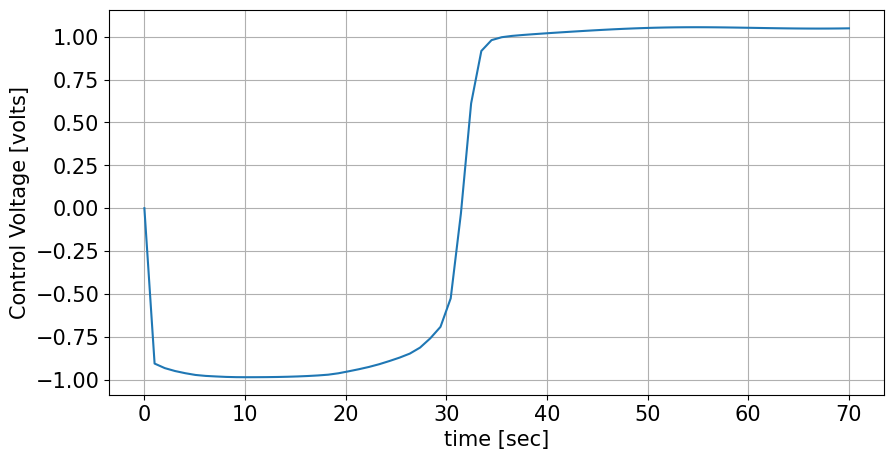

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)

plt.plot(time_, save_ctrl_voltage)
plt.xlabel("time [sec]")
plt.ylabel("Control Voltage [volts]")
plt.grid()
plt.show()

In [ ]:
np_array_MRAC_adapt_gains = np.array(save_MRAC_adapt_gains).T

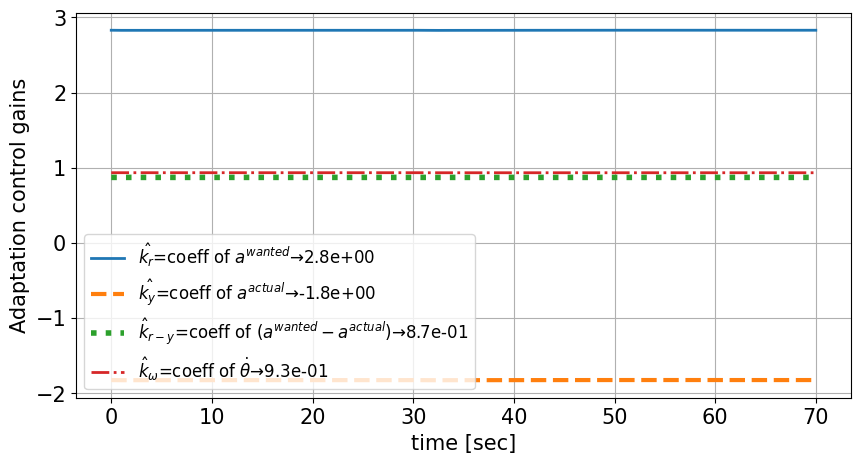

In [ ]:
font = {'size': 15}
plt.rc('font', **font)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

plt.plot(time_, np_array_MRAC_adapt_gains[0]
         ,label = r"$\hat{k_r}$=coeff of $a^{wanted}$"+f"→{np_array_MRAC_adapt_gains[0,-20:-1].mean():.1e}",color="C0",linewidth = 2)
plt.plot(time_, np_array_MRAC_adapt_gains[1],'--'
         ,label = r"$\hat{k_y}$=coeff of $a^{actual}$"+f"→{np_array_MRAC_adapt_gains[1,-20:-1].mean():.1e}",color="C1",linewidth = 3)
plt.plot(time_, np_array_MRAC_adapt_gains[2],':',
         label = r"$\hat{k}_{r-y}$=coeff of $(a^{wanted}-a^{actual})$"+f"→{np_array_MRAC_adapt_gains[2,-20:-1].mean():.1e}",color="C2",linewidth = 4)
plt.plot(time_, np_array_MRAC_adapt_gains[3],'-.',
         label = r"$\hat{k}_\omega$=coeff of $\dot{\theta}$"+f"→{np_array_MRAC_adapt_gains[3,-20:-1].mean():.1e}",color="C3",linewidth = 2)
plt.xlabel("time [sec]")
plt.ylabel("Adaptation control gains")
plt.grid()
plt.legend(fontsize=12)
plt.show()


In [ ]:
import math

position = []   #position of the car along the x-axis
velocity = []   #velocity of the car

for observ in save_observation:
  for index,value in enumerate(observ):
    if index == 0:
      position.append(value)

    if index == 1:
      velocity.append(value)

In [ ]:
print(len(position))

70


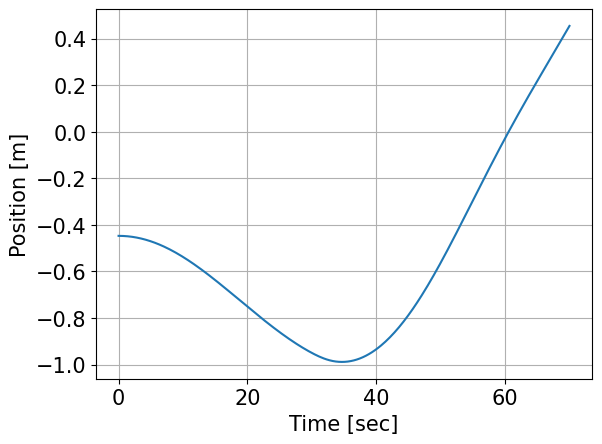

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

time_x_position = np.linspace(start = 0, stop = len(position)* dt ,num=len(position))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_x_position[-1] , 300)

spl = make_interp_spline(time_x_position, position, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Time [sec]")
plt.ylabel("Position [m]")
plt.grid()
plt.show()

In [ ]:
print("Car reached to goal afer "+str(time_x_position[-1])+ " seconds")

Car reached to goal afer 70.0 seconds


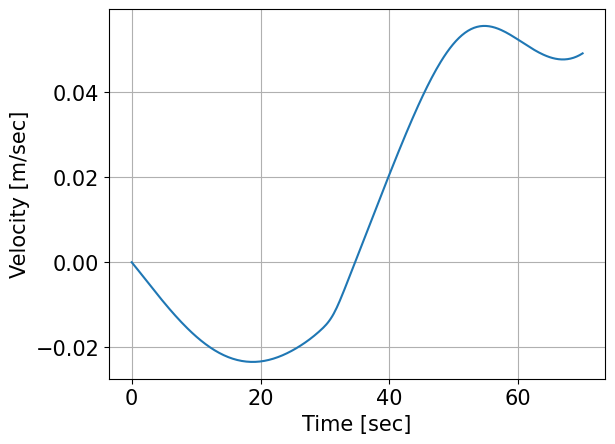

In [ ]:
time_velocity = np.linspace(start = 0, stop = len(velocity)* dt ,num=len(velocity))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(0, time_velocity[-1] , 300)

spl = make_interp_spline(time_velocity, velocity, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.xlabel("Time [sec]")
plt.ylabel("Velocity [m/sec]")
plt.grid()
plt.show()